In [14]:
from main import * 
from exp_runner import * 
from exp_utils import *
import requests
import pycountry_convert as pc
import pandas as pd
import os 
import dill
from time import perf_counter

In [15]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set_palette("husl")

In [19]:
urls = {
    'ARGENTINA': "exactas.uba.ar",
    'BOLIVIA': "www.uatf.edu.bo",
    'PERU': "www.unmsm.edu.pe",
    'BRASIL': "www5.usp.br",
    'CANADA': "www.uvic.ca",
    'UK': "129.67.242.155",
    'SUIZA': "ethz.ch",
    'RUSIA': "www.msu.ru",
    'ISRAEL': "www.technion.ac.il",
    'CHINA': "www.tsinghua.edu.cn",
    'AUSTRALIA': "130.56.66.152",
}

In [20]:
def get_info(url):
    url = 'http://ip-api.com/json/' + url
    info = requests.get(url=url, params={}).json()
    try:
        continent_code = pc.country_alpha2_to_continent_code(info['countryCode'])
        info.update({'continentCode': continent_code})
    except KeyError:
        info['countryCode'] = None
        info['continentCode'] = None
    return info 
info_dict = {key: get_info(url)['query'] for key, url in urls.items()}

In [21]:
def info_lookup(info_dict, ip):
    for key, value in info_dict.items():
        if value == ip:
            return key

In [158]:
sdl = superdataframemonolitico()
sdl = sdl.replace('cgiudice', 'Red 1')
sdl = sdl.replace('rbarylko', 'Red 2')
sdl = sdl.replace('dolmedo', 'Red 3')
sdl = sdl.replace('frosende', 'Red 4')

df = sdl.drop(columns=["retry", "timeout"])
df["ip"] = df.ip.apply(lambda ip: info_lookup(info_dict, ip))

### Resultados por red

In [159]:
def get_percentage(row):
    protocol_df = p_status_df[p_status_df.protocol == row.protocol]
    return 100 * round(row.times / sum(protocol_df[protocol_df.ip == row.ip].times), 3)

p_status_df = pd.DataFrame(df.groupby(["ip", "status", "protocol"]).size())
p_status_df.reset_index(inplace=True)
p_status_df.rename({0:"times"}, axis=1, inplace = True)

p_status_df["percentage"] = p_status_df.apply(get_percentage, axis=1)

In [160]:
sns.set_palette("husl")

g = sns.catplot(x="ip", y="percentage", hue="status", data=p_status_df, row="protocol", kind="bar", legend=False)
g.set_ylabels("Porcentaje de respuestas")
g.set_xlabels("Red")
plt.legend(title='Estado', bbox_to_anchor=(1.01, 1.3), loc='upper left', borderaxespad=0.)
fig = plt.gcf()
fig.set_size_inches(17, 7)

ax1, ax2 = g.axes
countries_count = len(set(p_status_df.ip))
for i in range(1, countries_count):
    ax1[0].axvline(i - 0.45, ls='--', color="black", alpha=0.3)
    ax2[0].axvline(i - 0.45, ls='--', color="black", alpha=0.3)

plt.show()

## Estado de los puertos

In [254]:
status_vals = set(df.apply(lambda row: (row.protocol, row.status), axis=1))
status_vals.add(("TCP", "others"))
colors = sns.husl_palette(len(status_vals))
color_dict = {status:color for status, color in zip(status_vals, colors)}

### Unas barras para mostrar los abiertos en UDP y los cerrados en TCP

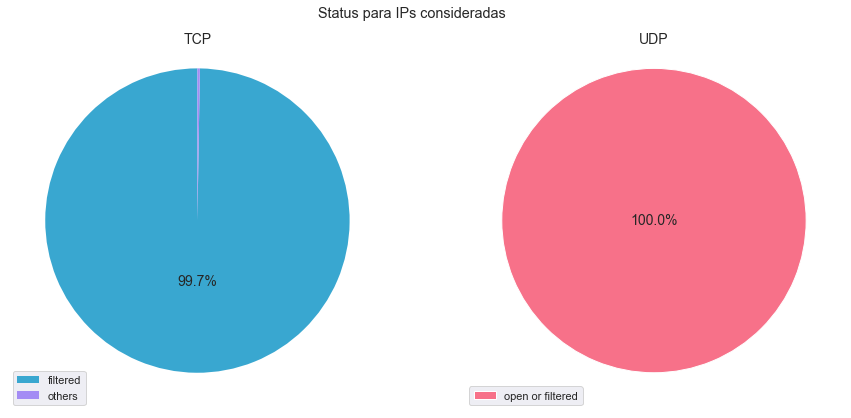

In [276]:
clean_df = df[~df['ip'].isin(["AUSTRALIA", "RUSIA", "SUIZA"])]

tcp_value_counts = clean_df[clean_df.protocol == "TCP"].status.value_counts()
udp_value_counts = clean_df[clean_df.protocol == "UDP"].status.value_counts()

def max_others(series):
    maxval = max(series)
    name = None
    others_val = 0
    for i in series.index:
        if series[i] == maxval:
            return maxval, sum(series) - maxval, i
            

tcp_max, tcp_others, tcp_name = max_others(tcp_value_counts)
udp_max, udp_others, udp_name = max_others(udp_value_counts)

def draw_pie(_max, _others, _name, _ax, _colors, _protocol):
    def make_autopct(pct):
        if pct > 1:
            return f"{round(pct, 1)}%"
    total = _max + _others
    if _max == total:
        colors=[_colors[(_protocol,_name)]]
        _ax.pie([_max/total], labels=[""], startangle=90, textprops={'fontsize': 14}, autopct=make_autopct, pctdistance=0, labeldistance=1.2, colors=colors)
        labels = [_name]
    else:
        colors=[_colors[(_protocol,_name)],_colors[(_protocol, "others")]]
        _ax.pie([_max/total, _others/total], labels=["", ""], startangle=90, pctdistance=0.4, textprops={'fontsize': 14}, autopct=make_autopct, colors=colors , wedgeprops = {'linewidth': 0})
        labels = [_name, "others"]
    _ax.set_title(_protocol, fontsize=14)
    ttl = _ax.title
    ttl.set_position([.5, .95])
    _ax.legend(loc=3, labels=labels)
    
colors = sns.husl_palette(5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
draw_pie(tcp_max, tcp_others, tcp_name, ax1, color_dict, "TCP")
draw_pie(udp_max, udp_others, udp_name, ax2, color_dict, "UDP")
fig.suptitle("Status para IPs consideradas", x=0.5, y=0.80)

plt.show()

### Puertos abiertos

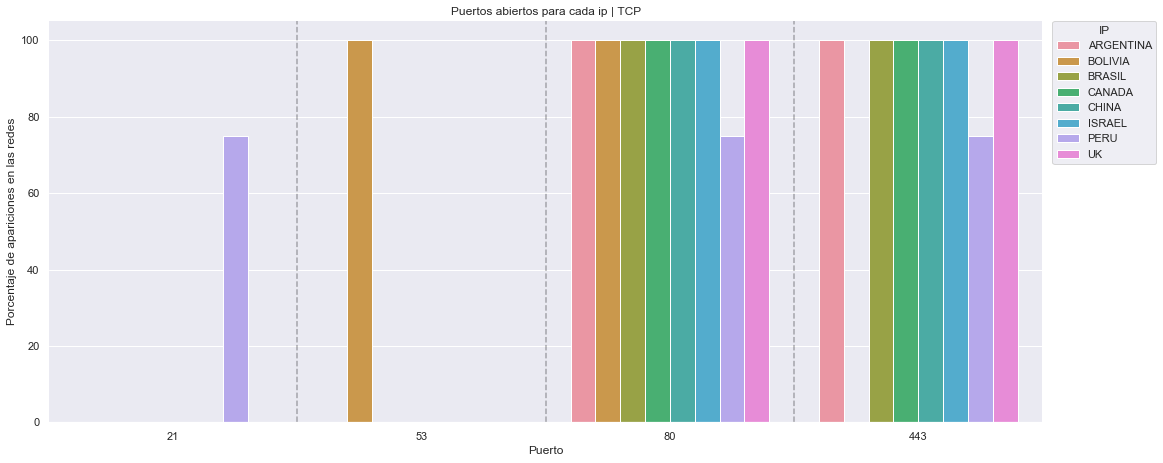

In [258]:
sns.set_palette("husl")

open_df = clean_df.groupby(['protocol', 'status']).get_group(('TCP','open SA'))

open_count_df = pd.DataFrame(open_df.groupby(["ip", "port", "protocol"]).size())
open_count_df.reset_index(inplace=True)
open_count_df.rename({0:"times"}, axis=1, inplace = True)
open_count_df["percentage"] = open_count_df.apply(lambda row: 100 * round(row.times / len(set(df.jobname)), 3), axis=1)

g = sns.catplot(x='port', y="percentage", hue='ip', row='protocol', data=open_count_df, kind='bar', legend=False)
g.set_ylabels("Porcentaje de apariciones en las redes")
g.set_xlabels("Puerto")
g.despine(left=True)
plt.legend(title='IP', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title('Puertos abiertos para cada ip | TCP')
fig = plt.gcf()
fig = plt.gcf()
fig.set_size_inches(17, 7)

ax1 = g.axes[0]
port_count = len(set(open_count_df.port))
for i in range(1, port_count):
    ax1[0].axvline(i - 0.50, ls='--', color="black", alpha=0.3)

plt.show()

## Raris

In [265]:
def draw_country_pie(series, ax, colordict, protocol):
    def make_autopct(pct):
        if pct > 20:
            return f"{round(pct, 1)}%"
    
    colors = [colordict[(protocol,i)] for i in series.index]
    ax.pie(series, labels=[""]*len(series), startangle=90, pctdistance=0.4, textprops={'fontsize': 14}, autopct=make_autopct, colors=colors)
    ax.set_title(protocol, fontsize=14)
    ttl = ax.title
    ttl.set_position([.5, .95])
    ax.legend(loc=3, labels=series.index)

### Australia

In [266]:
australia_df = df[df.ip == "AUSTRALIA"]
aus_tcp_value_counts = australia_df[australia_df.protocol == "TCP"].status.value_counts(True)
aus_udp_value_counts = australia_df[australia_df.protocol == "UDP"].status.value_counts(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
draw_country_pie(aus_tcp_value_counts, ax1, color_dict, "TCP")
draw_country_pie(aus_udp_value_counts, ax2, color_dict, "UDP")
fig.suptitle("Australia", x=0.5, y=0.95)

plt.show()

### Rusia

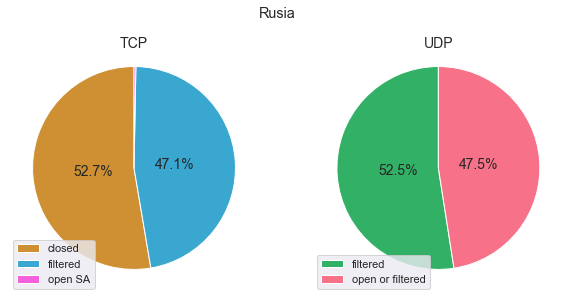

In [268]:
rusia_df = df[df.ip == "RUSIA"]
rus_tcp_value_counts = rusia_df[rusia_df.protocol == "TCP"].status.value_counts(True)
rus_udp_value_counts = rusia_df[rusia_df.protocol == "UDP"].status.value_counts(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
draw_country_pie(rus_tcp_value_counts, ax1, color_dict, "TCP")
draw_country_pie(rus_udp_value_counts, ax2, color_dict, "UDP")
fig.suptitle("Rusia", x=0.5, y=0.95)

plt.show()

### Suiza

In [269]:
suiza_df = df[df.ip == "SUIZA"]
suiz_tcp_value_counts = suiza_df[suiza_df.protocol == "TCP"].status.value_counts()
suiz_udp_value_counts = suiza_df[suiza_df.protocol == "UDP"].status.value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
draw_country_pie(suiz_tcp_value_counts, ax1, color_dict, "TCP")
draw_country_pie(suiz_udp_value_counts, ax2, color_dict, "UDP")
fig.suptitle("Suiza", x=0.5, y=0.95)

plt.show()

## Puertos locos

In [11]:
import os
from exp_utils import *

exps = {}
for d in os.listdir("./data"):
    if "bokita" in d:
        exps[d] = load_port_scanners_from_jobname(d)
dff = bokita(exps)

In [24]:
dff[dff.status == "open SA"][0:5]

jobname             ip  timeout  retry  port protocol   status
160  rbarylko_bokita  130.56.66.152      1.0      0  2525      TCP  open SA
161  rbarylko_bokita  130.56.66.152      1.0      0  3306      TCP  open SA
162  rbarylko_bokita  130.56.66.152      1.0      0  2082      TCP  open SA
163  rbarylko_bokita  130.56.66.152      1.0      0  2083      TCP  open SA
164  rbarylko_bokita  130.56.66.152      1.0      0  2086      TCP  open SA

### Tablas